In [1]:
%run supportvectors-common.ipynb



<div style="color:#aaa;font-size:8pt">
<hr/>

 </blockquote>
 <hr/>
</div>



# Semantic search

Traditionally, one would search through a corpus of documents using a keywords-based search engine like Lucene, Solr, ElasticSearch, etc. While the technology has matured, the basic underlying approach behind keyword search engines is to maintain an *inverted-index* mapping keywords to a list of documents that contain them, with associated relevances.

In general, the keywords-based search approach has been quite successful over the years, and have matured with added features and linguistic capabilities.

However, this approach has had its limitations. The principal cause of it goes to the fact that when we enter keywords, it is a human tendency to describe the intent of what we are looking for. For example, if we enter "breakfast places", we implicitly also mean restaurants, cafe, etc that serve items appropriate for breakfast. There may be a restaurant described as a shop for expresso, or crepe, that a keywords-search will likely miss, since its keywords do not match the query terms. And yet, we would hope to see it near the top of the search results.

Semantic search is an NLP approach largely relying on deep-neural networks, and in particular, the transformers that make it possible to more closely infer the human intent behind the search terms, the relationship between the words, and the underlying context. It allows for entire sentences -- and even paragraphs -- describing what the searcher's intent is, and retrieves results more relevant or aligned to it.

## How would we do this NLP task with AI?

Let us represent the functional behavior we expect: 


![](images/semantic-search-functionality.png)


### Magic happens: breaking it down into steps

We recall that machine-learning algorithms work with vectors ($\mathbf{X}$) representation of data.

So the first order of business would be to map each of the document texts $D_i$ to its corresponding vector $X_i$ in an appropriate $d$-dimensional space, $\mathbb{R}^d$, i.e.

\begin{equation}
D_i \longrightarrow X_i \in \mathbb{R}^d
\end{equation}

This resulting vectors are called **sentence embeddings**. Once these embeddings are for each of the documents, we can store the collection of tuples $[<D_1, X_1>, <D_2, X_2>, ..., <D_n, X_n>]$. Here each tuple corresponds to a document and its sentence embedding.

This collection of tuples, therefore, becomes our **search index**.

### Search

Now, when the user described what she is looking for, we consider the entire text as a "sentence".
<p>
<div class="alert-box alert-warning" style="padding-top:30px">
   
<b >Caveat Emptor</b>

> Note that we have a rather relaxed definition of a *sentence* in NLP: it diverges from a grammmatical definition of a sentence somewhat.  For example, in the English language, we would consider a sentence to be terminated with a punctuation, such as a period, question-mark or exclamation. However, in NLP, we loosely consider the entire text -- whether it is just a word, or a few keywords, or an english sentence, or a few sentences together -- as one **sentence** for the purposes of natual language processing task.
    
<p>
</div>
    
Therefore, it is common to consider an entire document text as a *sentence* if the text is relatively short. Alternatively, it is partitioned into smaller chunks (of say 512-tokens each), and each such chunk is considered an NLP *sentence*.

Since we consider the entire query text as a sentence, we can map it to its **sentence embedding vector**, ${Q}$.

#### Vector Similarity
Once we have this, we simply need to compare the query vector ${Q}$ with each of the document vectors $X_i$, and sort the document vectors in descending order of similarity.

The rest is trivial: pick the top-k  in the sorted document vectors list. Then for each vector, look up its corresponding document, and return the list as sorted search result of relevant document.

We expect that these documents will exhibit high semantic similarity with the search query, assuming that the search index did contain such documents.

<figure>
    <img src="https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SemanticSearch.png">
    <caption> Semantic similarity as vector proximity in the embedding space. <br>
    (Figure source: Sbert.net documentation).
    </caption>
</figure>


#### Similarity measures

The sentence embedding vectors typically exist in very large dimensional space (e.g., 300 dimensions). In such large dimensional spaces, the notion of euclidean distance is not as effective. Therefore, it is far more common to use one of the two below measures for vector similarity:

* **dot-product**, the (inner) dot-product between the embedding vectors.

\begin{equation}
\text{dot-similarity} = \langle X_i, X_j \rangle
\end{equation}

* **cosine-similarity**, the $\cos \left(\theta_{ij}\right)$ gives degree of directional alignment between the vectors, but ignores their magnitudes. Here, $\theta_{ij}$ is the angle between $X_i$ and $X_j$ (embedding) vectors.

\begin{equation} 
\text{cosine-similarity} = \frac{\langle X_i, X_j \rangle} {\| X_i \| \| X_j \|}
\end{equation}

<div class="alert-box alert-info" style="padding-top:30px">
   
**Important**
    
>  Sentence transformer models trained with cosine-similarity tend to favor the shorter document texts in the search results, whereas the models trained on the dot-product similarity tend to favor longer texts.
</div>

### Symmetric vs asymmetric search

One of the technical aspects to be careful of is the relative textual length of the query sentence compared to the actual documents. Different sentence-transformer models have been trained specifically for each of these use-cases. 

* **symmetric search** when we expect the query-sentence to be approximately the same length as the document sentences.

* **asymmetric search** when we expect the document texts to be significantly larger in length to the query sentence.



#### Load an appropriate model

Let us consider the use-case where we are searching through some reasonably large documents. In such a case, it would be appropriate to use an asymmetric-search model. 

Let us consider an asymmetric model trained with *cosine-similarity* as the distance measure. In particular, let us use one of the below models:

* `


We load the model with the following code:

In [2]:
from sentence_transformers import SentenceTransformer

MODEL = 'msmarco-distilbert-base-v4'
embedder = SentenceTransformer(MODEL)

#### Load a toy corpus

Let us now load a toy corpus of some simple, long texts.

In [3]:
%run NLP-Lesson-01___search-corpus.ipynb

#### Search index of sentence embeddings

Let us now create the search index of sentence embeddings.

In [4]:
embeddings = embedder.encode(sentences, convert_to_tensor=True)

Note that we chose to get the embeddings as `pytorch` tensors -- this will help us later in doing high-performance searches over the GPU/TPU hardware. What do these embeddings look like? 

In [5]:
embeddings.shape

torch.Size([16, 768])

Clearly, there are 16 embeddings, each of a 768 dimensional vector. Let us glance at a sentence, and its embedding:

In [6]:
print (f'{sentences[0]}  {embeddings[0]}')


’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.

“Beware the Jabberwock, my son!
      The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
      The frumious Bandersnatch!”

He took his vorpal sword in hand;
      Long time the manxome foe he sought—
So rested he by the Tumtum tree
      And stood awhile in thought.

And, as in uffish thought he stood,
      The Jabberwock, with eyes of flame,
Came whiffling through the tulgey wood,
      And burbled as it came!

One, two! One, two! And through and through
      The vorpal blade went snicker-snack!
He left it dead, and with its head
      He went galumphing back.

“And hast thou slain the Jabberwock?
      Come to my arms, my beamish boy!
O frabjous day! Callooh! Callay!”
      He chortled in his joy.

’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mo

#### Now, search for something!

Let us find the closest match to the the query: "a friendship with animals"

In [7]:
query_text = "a friendship with animals"
query = embedder.encode(query_text, convert_to_tensor=True)

In [8]:
from sentence_transformers import util
search_results = util.semantic_search(query, embeddings, top_k = 3)
search_results

[[{'corpus_id': 7, 'score': 0.2550491690635681},
  {'corpus_id': 8, 'score': 0.23244595527648926},
  {'corpus_id': 5, 'score': 0.21887622773647308}]]

In [9]:
for index, result in enumerate(search_results[0]):
    print('-'*80)
    print(f'Search Rank: {index}, Relevance score: {result["score"]} ')
    print(sentences[result['corpus_id']])
    

--------------------------------------------------------------------------------
Search Rank: 0, Relevance score: 0.2550491690635681 

Golden retrievers are not bred to be guard dogs, and considering the size of their hearts and their irrepressible joy and life, they are less likely to bite than to bark, less likely to bark than to lick a hand in greeting. In spite of their size, they think they are lap dogs, and in spite of being dogs, they think they’re also human, and nearly every human they meet is judged to have the potential to be a boon companion who might at any moment, cry, “Let’s go!” and lead them on a great adventure.

--------------------------------------------------------------------------------
Search Rank: 1, Relevance score: 0.23244595527648926 

If you’re lucky, a golden retriever will come into your life, steal your heart, and change everything

--------------------------------------------------------------------------------
Search Rank: 2, Relevance score: 0.218876

## Visual Search

Let us now search by giving it an image of what we are looking for. How can we do this?

We need to translate an image into an embedding vector, in a semantically relevant manner. If we were to be able to do it, we can then search through our document embeddings in essentially  the same manner as we did for textual search.

We start by getting an image from the web:

<figure style="padding:30px">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/At_Sticker_Lumis_Golden.JPG/1920px-At_Sticker_Lumis_Golden.JPG">
    <caption> A golden retriever image from wikipedia </caption>
</figure>



In [10]:
from PIL import Image
# Create the model
CLIP_MODEL = 'clip-ViT-B-32'
embedder = SentenceTransformer(CLIP_MODEL)

# We need to take smaller text, for CLIP to work. (current limitation)
short_sentences = [
    'A smiling dog', 'House with a chimney', 'Car on a highway',
    'Elephant in the field', 'Attention is all you need',
    'Golden retrievers are little children', 'A cat on the window sill',
    'For the love of these furry dogs'
]
# Create the search index of embeddings
embeddings = embedder.encode(short_sentences, convert_to_tensor=True)
embeddings.shape

torch.Size([8, 512])

#### Image as query

In [11]:
query = embedder.encode(Image.open('images/dog.jpeg'))

In [12]:
from sentence_transformers import util
search_results = util.semantic_search(query, embeddings, top_k = 3)
search_results

[[{'corpus_id': 5, 'score': 0.26912161707878113},
  {'corpus_id': 7, 'score': 0.2506452202796936},
  {'corpus_id': 0, 'score': 0.24110287427902222}]]

In [13]:
for index, result in enumerate(search_results[0]):
    print('-'*80)
    print(f'Search Rank: {index}, Relevance score: {result["score"]} ')
    print(short_sentences[result['corpus_id']])
    

--------------------------------------------------------------------------------
Search Rank: 0, Relevance score: 0.26912161707878113 
Golden retrievers are little children
--------------------------------------------------------------------------------
Search Rank: 1, Relevance score: 0.2506452202796936 
For the love of these furry dogs
--------------------------------------------------------------------------------
Search Rank: 2, Relevance score: 0.24110287427902222 
A smiling dog


### Text as query

We can also do the converse: give a text query, and retrieve all images that match. 

<div class="alert-box alert-info" style="padding-top:30px">
   
**Attribution**
    
>  The following example is derived from, and inspired by, the sample jupyter notebook posted at:  https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/image-search/Image_Search.ipynb
</div>

Let us first download a collection of photos from the Unsplash website of free available photos.

In [14]:
# Taken almost verbatim from the above-mentioned resource.
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

### Create the search index of these images

Let us now create a search index of these images as a collection of sentence embeddings. Since it is rather computationally expensive and time-consuming to create these embeddings, let us also store it for repeated use. 

Of-course, this implies that the next time you run this cell, it will retrieve the pre-computed embeddings, rather than recreate them.

In [15]:
# Once again, this code is taken from the sample notebook mentioned above.

model = SentenceTransformer('clip-ViT-B-32')
use_precomputed_embeddings = True

if use_precomputed_embeddings:
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):  #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/' + emb_filename,
                      emb_filename)

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names],
                           batch_size=128,
                           convert_to_tensor=True,
                           show_progress_bar=True)

  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


### Image search with prompts

Now we can search in a manner exactly the same as before.

In [16]:
!pip install ipyplot
import ipyplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
# Let us define a search function
from typing import Union
def search(query: str, is_image: bool = False, k:int = 8):    
    raw = Image.open(query) if is_image else query
    query_emb = model.encode([raw], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(raw) if is_image else display(query)
    images = [os.path.join(img_folder, img_names[hit['corpus_id']]) for hit in hits]
    ipyplot.plot_images(images, max_images=30, img_width=150, show_url=False)
    

In [60]:
search('To love a dog')

Query:


'To love a dog'

In [61]:
search('House near a lake')

Query:


'House near a lake'

In [62]:
search('jumping dog')

Query:


'jumping dog'

In [63]:
search('Pathways through the forest')

Query:


'Pathways through the forest'

## Homework

Perform a search, where the query is an image, and the results are images.

Query:


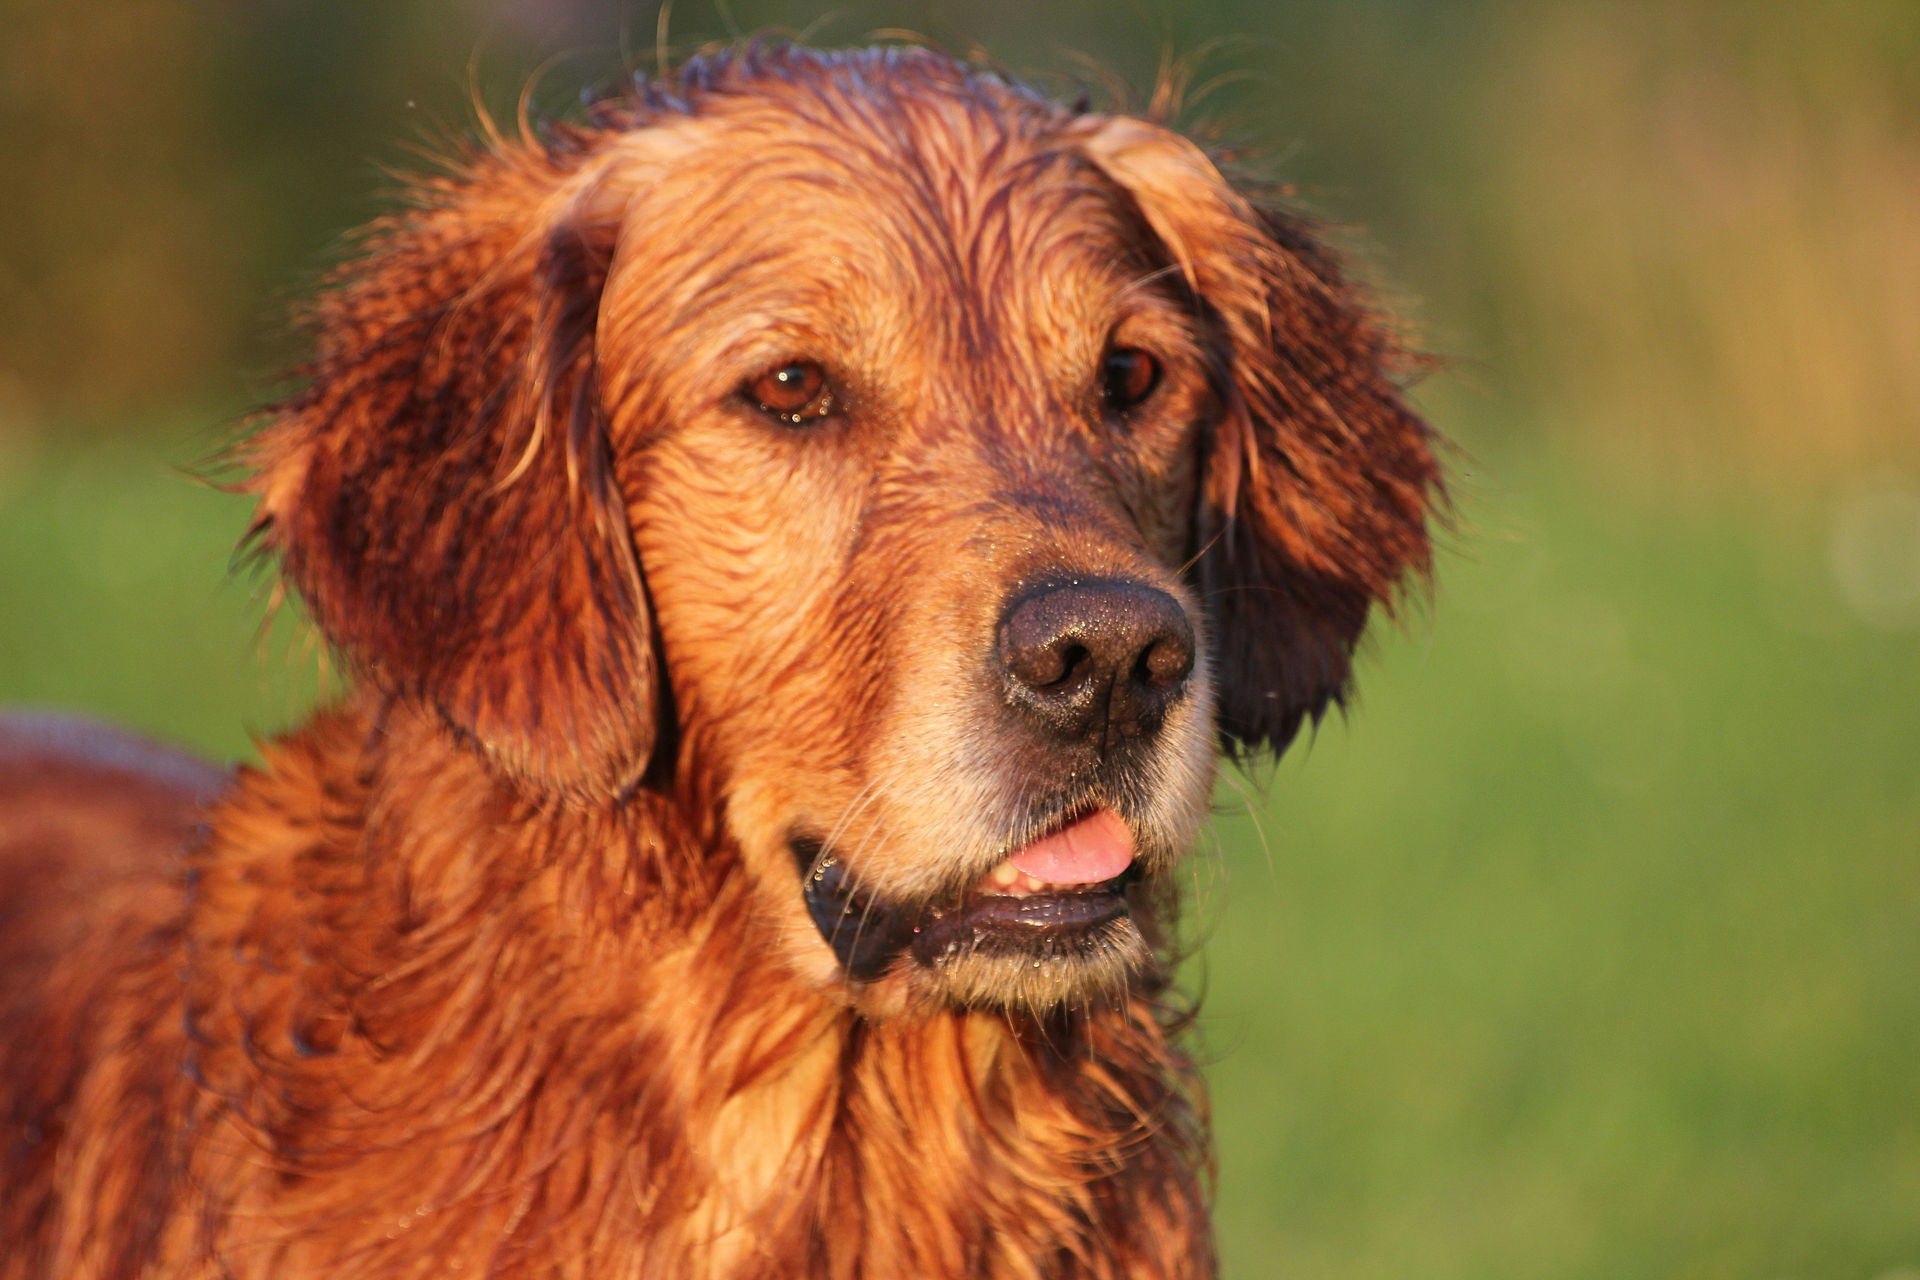

In [68]:
dog = 'images/dog.jpeg'
search(dog, k=10, is_image=True)

## References

Further reading resources associated with the two topics: sentence-transformers and approximate nearest neighbor searches.
<p>

* <a href="https://sbert.net/">Sentence Transformers</a> 

* The original paper that introduced sentence-transformers: <a href="https://arxiv.org/abs/1908.10084">Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks</a>

* Faiss blog at facebook <a href="https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/"> Faiss: A library for efficient similarity search </a>

* A gentler introduction to Faiss: <a href="https://github.com/facebookresearch/faiss/wiki/"> Faiss wiki </a>

* Faiss <a href="https://github.com/facebookresearch/faiss">The Faiss github repository </a>

* Approximate nearest neighbor search with ScaNN <a href="https://github.com/google-research/google-research/tree/master/scann"> Scann github repository</a>

* Scann research paper: <a href="https://arxiv.org/abs/1908.10396">  Accelerating Large-Scale Inference with Anisotropic Vector Quantization </a>
    
* Topic modeling: <a href="https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6">Topic modeling with BERT </a>
    
* To2Vec research paper: <a  href="https://arxiv.org/abs/2008.09470">Top2Vec: Distributed Representations of Topics</a>


In [ ]:
#!pip install bertopic  #Do it only once!

In [94]:
# Fetch the famous 20-newsgroup data
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

from bertopic import BERTopic
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

ImportError: cannot import name 'UMAP' from 'umap' (/home/asif/anaconda3/lib/python3.9/site-packages/umap/__init__.py)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-linux_x86_64.whl size=744970 sha256=3854e88e44fd1ee04498a8a25a722dc4514916ba336b2ed496085368ad8acc93
  Stored in directory: /home/asif/.cache/pip/wheels/05/6f/88/1a4c04276b98306f00217a1e300e6ba0252c6aa4f7616067ae
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [89]:
from umap import umap_ as UMAP
umap_embeddings = UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

TypeError: 'module' object is not callable

In [75]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


ModuleNotFoundError: No module named 'hdbscan'